In [1]:
# Declaración de librerías
import nltk
import numpy
import tensorflow
import random
import json

2023-10-18 13:05:09.164712: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-18 13:05:10.450247: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-18 13:05:10.450349: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-18 13:05:10.455953: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-18 13:05:10.974241: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-18 13:05:10.981178: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
# Lectura de formatos .json para entrenar cada modelo y asignación
# de información correspondiente
with open('Intenciones_NivelI.json', encoding='utf-8') as file:
    data_NivelI = json.load(file)
    
with open('Intenciones_NivelIIA.json', encoding='utf-8') as file:
    data_NivelIIA = json.load(file)
    
with open('Intenciones_NivelIIB.json', encoding='utf-8') as file:
    data_NivelIIB = json.load(file)

In [3]:
# Creación de diccionarios con los nombres de las clases y textos
# presentes en cada uno de los archivos
NI = dict()
NIIA = dict()
NIIB = dict()
NIIC = dict()

for info in data_NivelI['intents']:
    NI.setdefault(info['tag'], info['patterns'])

for info in data_NivelIIA['intents']:
    NIIA.setdefault(info['tag'], info['patterns'])
    
for info in data_NivelIIB['intents']:
    NIIB.setdefault(info['tag'], info['patterns'])
        
print(NI)
print(NIIA)
print(NIIB)
print(NIIC)

{'Jugar_Juego': ['Quiero jugar un juego', '¿Qué tal si jugamos un juego?', 'Juguemos un juego', '¿Qué juegos conoces', 'Podemos jugar un juego', 'Juguemos algo', 'Quiero que juguemos', 'Vamos a jugar un juego'], 'Reproducir_Musica': ['Quiero escuchar música', '¿Puedes reproducir música?', 'Quiero que reproduzcas música', 'Quiero que pongas una canción', 'Activa el reproductor de música', 'Me agradaría escuchar algo de música', 'Puedes poner música en algún servicio de streamming', 'Abre el reproductor musical por favor'], 'Mortal_Kombat': ['Quiero saber más de Mortal Kombat', '¿Puedes decirme cual es el mejor personaje?', 'Quiero que pongas e juego de Mortal Kombat', 'Pudes decirme los combos para jugar Sub-Zero', '¿Qué tiene de diferente Mortal Kombat 11 con Mortal Kombat 1?', 'Me agradaría jugar Mortal Kombat', 'Puedes iniciar el juego de Mortal Kombat', 'Enciende el Xbox por favor']}
{'Adivinanzas': ['Vamos a jugar a las adivinanzas', 'Quiero jugar adivinanzas', 'Juguemos adivinanza

In [4]:
# Generamos los vectores de respuestas para cada nivel contextual
# (Cada clase tiene una salida numérica asociada)
# (Las salidas empiezan en 0 para cada clase inicial de cada modelo)
Y_NI = list()
Y_NIIA = list()
Y_NIIB = list()

for clase, lista_textos in NI.items():
    for text in lista_textos:
        Y_NI.append(list(NI.keys()).index(clase))
        
for clase, lista_textos in NIIA.items():
    for text in lista_textos:
        Y_NIIA.append(list(NIIA.keys()).index(clase))
        
for clase, lista_textos in NIIB.items():
    for text in lista_textos:
        Y_NIIB.append(list(NIIB.keys()).index(clase))
    
print("Vector de salidas Y para N1:")
print(Y_NI)
print("Vector de salidas Y para N2A:")
print(Y_NIIA)
print("Vector de salidas Y para N2B:")
print(Y_NIIB)

Vector de salidas Y para N1:
[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2]
Vector de salidas Y para N2A:
[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2]
Vector de salidas Y para N2B:
[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2]


In [5]:
# Importamos librerías para el filtrado de StopWords y tokenicación
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
import re

stop_words = set(stopwords.words('spanish'))

In [6]:
# Para cada enunciado quitamos las StopWords
# También quitamos los acentos y filtramos signos de puntuación
# lo hacemos mediante un metodo
def Quitar_Stopwords(Textos):
    X = list()
    for sen in Textos:
        sentence = sen
        # Filtrado de stopword
        for stopword in stop_words:
            sentence = sentence.replace(" " + stopword + " ", " ")
        sentence = sentence.replace("á", "a")
        sentence = sentence.replace("é", "e")
        sentence = sentence.replace("í", "i")
        sentence = sentence.replace("ó", "o")
        sentence = sentence.replace("ú", "u")

        # Remover espacios múltiples
        sentence = re.sub(r'\s+', ' ', sentence)
        # Convertir todo a minúsculas
        sentence = sentence.lower()
        # Filtrado de signos de puntuación
        tokenizer = RegexpTokenizer(r'\w+')
        # Tokenización del resultado
        result = tokenizer.tokenize(sentence)
        # Agregar al arreglo los textos "destokenizados" (Como texto nuevamente)
        X.append(TreebankWordDetokenizer().detokenize(result))
    return X

In [7]:
# Obtenemos el vector de entradas (Textos limpios de StopWords)
# para cada uno de los modelos que vamos a generar
Textos_NI = list()
for Lista in NI.values():
    for Texto in Lista:
        Textos_NI.append(Texto)
        
X_NI = Quitar_Stopwords(Textos_NI)

Textos_NIIA = list()
for Lista in NIIA.values():
    for Texto in Lista:
        Textos_NIIA.append(Texto)
        
X_NIIA = Quitar_Stopwords(Textos_NIIA)

Textos_NIIB = list()
for Lista in NIIB.values():
    for Texto in Lista:
        Textos_NIIB.append(Texto)
        
X_NIIB = Quitar_Stopwords(Textos_NIIB)

In [8]:
# Imprimimos la lista de los enunciados que resultan
print(X_NI)
print(X_NIIA)
print(X_NIIB)


['quiero jugar juego', 'que tal si jugamos juego', 'juguemos juego', 'que juegos conoces', 'podemos jugar juego', 'juguemos algo', 'quiero juguemos', 'vamos jugar juego', 'quiero escuchar musica', 'puedes reproducir musica', 'quiero reproduzcas musica', 'quiero pongas cancion', 'activa reproductor musica', 'me agradaria escuchar musica', 'puedes poner musica algun servicio streamming', 'abre reproductor musical favor', 'quiero saber mortal kombat', 'puedes decirme mejor personaje', 'quiero pongas juego mortal kombat', 'pudes decirme combos jugar sub zero', 'que diferente mortal kombat 11 mortal kombat 1', 'me agradaria jugar mortal kombat', 'puedes iniciar juego mortal kombat', 'enciende xbox favor']
['vamos jugar adivinanzas', 'quiero jugar adivinanzas', 'juguemos adivinanzas', 'quisiera jugar adivinar cosas', 'sabes jugar adivinanzas', 'quiero digas intente adivinar', 'puedes jugar adivinanzas conmigo', 'quiero juegues conmigo adivinar cosas', 'juguemos 20 preguntas', 'sabes como jug

In [9]:
# Importamos la librería para generar la matriz de entrada de textos
# (El pad_sequence)
from keras_preprocessing.sequence import pad_sequences

# Cantidad de palabras máximas por ejemplo
# (Las más utilizadas)
maxlen = 5

# Preparamos la capa de embeddingsn(Predefinimos una cantidad de
# 5000 palabras consideradas como tokens
tokenizer_NI = Tokenizer(num_words=5000)
tokenizer_NIIA = Tokenizer(num_words=5000)
tokenizer_NIIB = Tokenizer(num_words=5000)

# Transforma cada texto en una secuencia de valores enteros para cada modelo que haremos
tokenizer_NI.fit_on_texts(X_NI)
X_NI_Tok = tokenizer_NI.texts_to_sequences(X_NI)
tokenizer_NIIA.fit_on_texts(X_NIIA)
X_NIIA_Tok = tokenizer_NIIA.texts_to_sequences(X_NIIA)
tokenizer_NIIB.fit_on_texts(X_NIIB)
X_NIIB_Tok = tokenizer_NIIB.texts_to_sequences(X_NIIB)

# Especificamos la matriz (Con padding hasta maxlen)
X_NI_train = pad_sequences(X_NI_Tok, padding='post', maxlen=maxlen)
X_NIIA_train = pad_sequences(X_NIIA_Tok, padding='post', maxlen=maxlen)
X_NIIB_train = pad_sequences(X_NIIB_Tok, padding='post', maxlen=maxlen)


In [10]:
print("Matriz de entrada para NI:")
print(X_NI_train)

Matriz de entrada para NI:
[[ 1  6  2  0  0]
 [ 8 17 18 19  2]
 [ 9  2  0  0  0]
 [ 8 20 21  0  0]
 [22  6  2  0  0]
 [ 9 23  0  0  0]
 [ 1  9  0  0  0]
 [24  6  2  0  0]
 [ 1 10  3  0  0]
 [ 7 25  3  0  0]
 [ 1 26  3  0  0]
 [ 1 11 27  0  0]
 [28 12  3  0  0]
 [13 14 10  3  0]
 [29  3 30 31 32]
 [33 12 34 15  0]
 [ 1 35  4  5  0]
 [ 7 16 36 37  0]
 [ 1 11  2  4  5]
 [16 39  6 40 41]
 [ 5 43  4  5 44]
 [13 14  6  4  5]
 [ 7 45  2  4  5]
 [46 47 15  0  0]]


In [11]:
print("Matriz de entrada para NIIA:")
print(X_NIIA_train)

Matriz de entrada para NIIA:
[[20  1  6  0  0]
 [ 3  1  6  0  0]
 [ 8  6  0  0  0]
 [21  1  9 12  0]
 [10  1  6  0  0]
 [ 3 22 23  9  0]
 [13  1  6 14  0]
 [ 3 24 14  9 12]
 [ 8  4  2  0  0]
 [10 15  1  4  2]
 [ 3  1  4  2  0]
 [ 8  4  2 25  0]
 [ 3  1  5  2  0]
 [26  2 27  9 16]
 [16 30 31  4  2]
 [32  5  4  2  0]
 [ 3  1 11  7  0]
 [13 33  5 11  7]
 [10 15  1 11  7]
 [ 2 17 18  0  0]
 [ 2 34 19 35 36]
 [37 10  5 38  7]
 [ 2 42 19 17 18]
 [43  3  8 11  7]]


In [12]:
print("Matriz de entrada para NIIB:")
print(X_NIIB_train)

Matriz de entrada para NIIB:
[[ 3  0  0  0  0]
 [ 4  3  0  0  0]
 [ 8 20  3 14  0]
 [15 21  3  0  0]
 [ 4  1 16 14 22]
 [10  1 16 23  0]
 [ 5  4  3 24  7]
 [11  5 25  7  3]
 [ 6  0  0  0  0]
 [ 4  1  6  0  0]
 [ 5  4  1 17  7]
 [26 27 18 17 28]
 [29  1 18  6  0]
 [ 4  6  5  0  0]
 [19 12  6  0  0]
 [ 8 13  7  6  0]
 [19  2  0  0  0]
 [30  2  9  5  0]
 [31 12  2  9  0]
 [10  1  2  0  0]
 [ 1 32 33 34 35]
 [36 12  2  9 37]
 [ 8 13 38 39  2]
 [13  7  2  9  5]]


In [13]:
# Declaración de librerías para manejo de arreglos (Numpy)
from numpy import asarray
from numpy import zeros

# Lectura del archivo de embeddings
embeddings_dictionary = dict()
Embeddings_file = open('/home/dati/Desktop/UP/Word2Vect_Spanish.txt', encoding="utf8")

# Extraemos las características del archivo de embeddings
# y las agregamos a un diccionario (Cada elemento es un vextor)
for linea in Embeddings_file:
    caracts = linea.split()
    palabra = caracts[0]
    vector = asarray(caracts[1:], dtype='float32')
    embeddings_dictionary [palabra] = vector
Embeddings_file.close()

In [14]:
# Asignamos los embeddings correspondientes a cada matriz 
# con la que se entrenarán los modelos por medio de un método
def Asignar_Embeddings(tokenizer, vocab_size):
    # Generamos la matriz de embeddings (Con 300 Características)
    embedding_matrix = zeros((vocab_size, 300))
    for word, index in tokenizer.word_index.items():
        # Extraemos el vector de embedding para cada palabra
        embedding_vector = embeddings_dictionary.get(word)
        # Si la palbra si existía en el vocabulario
        # agregamos su vector de embeddings en la matriz
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
    return embedding_matrix

In [15]:
# Obtenemos las matrices de Embeddings para cada modelo
# Y también el tamaño del vocabulario para cada uno
vocab_size_NI = len(tokenizer_NI.word_index) + 1
embedding_matrix_NI = Asignar_Embeddings(tokenizer_NI, vocab_size_NI)

vocab_size_NIIA = len(tokenizer_NIIA.word_index) + 1
embedding_matrix_NIIA = Asignar_Embeddings(tokenizer_NIIA, vocab_size_NIIA)

vocab_size_NIIB = len(tokenizer_NIIB.word_index) + 1
embedding_matrix_NIIB = Asignar_Embeddings(tokenizer_NIIB, vocab_size_NIIB)

In [16]:
# Declaración de modelo Secuencial que usaremos para todos los casos
try:
    from keras.models import Sequential
    from keras.layers.core import Dense
    from keras.layers import LSTM
    from keras.layers import Embedding
except:
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense
    from tensorflow.keras.layers import LSTM
    from tensorflow.keras.layers import Embedding


In [17]:
# Definición del método para tener la arquitectura de los modelos para cada nivel contextual
def Definir_Modelos(vocab_size, embedding_matrix, X_train, labels):
    # Declaración de las capas del modelo LSTM
    model = Sequential()
    embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=X_train.shape[1] , trainable=False)
    model.add(embedding_layer)
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(len(labels), activation='softmax'))

    # Compilación del modelo
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())

    print("\nPalabras en el vocabulario:")
    print(vocab_size)
    return model

In [18]:
# Generamos la arquitectura para el modelo de NI
model_NI = Definir_Modelos(vocab_size_NI, embedding_matrix_NI, X_NI_train, NI.keys())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5, 300)            14400     
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 3)                 303       
                                                                 
Total params: 175103 (684.00 KB)
Trainable params: 160703 (627.75 KB)
Non-trainable params: 14400 (56.25 KB)
_________________________________________________________________
None

Palabras en el vocabulario:
48


In [19]:
# Generamos la arquitectura para el modelo de NIIA
model_NIIA = Definir_Modelos(vocab_size_NIIA, embedding_matrix_NIIA, X_NIIA_train, NIIA.keys())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 5, 300)            13200     
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense_1 (Dense)             (None, 3)                 303       
                                                                 
Total params: 173903 (679.31 KB)
Trainable params: 160703 (627.75 KB)
Non-trainable params: 13200 (51.56 KB)
_________________________________________________________________
None

Palabras en el vocabulario:
44


In [20]:
# Generamos la arquitectura para el modelo de NIIB
model_NIIB = Definir_Modelos(vocab_size_NIIB, embedding_matrix_NIIB, X_NIIB_train, NIIB.keys())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 5, 300)            12300     
                                                                 
 lstm_2 (LSTM)               (None, 100)               160400    
                                                                 
 dense_2 (Dense)             (None, 3)                 303       
                                                                 
Total params: 173003 (675.79 KB)
Trainable params: 160703 (627.75 KB)
Non-trainable params: 12300 (48.05 KB)
_________________________________________________________________
None

Palabras en el vocabulario:
41


In [21]:
# Declaramos el método para entrenar cada modelo
try:
    from keras.utils.np_utils import to_categorical 
except:
    from tensorflow.keras.utils import to_categorical

def Entrenar_Modelos(X_train, Y, model, labels):
    # Declaramos librería para convertir la salida en un vector 
    # de X elementos con activación en la columna correspondiente
    # a su categoría
    train_labels = to_categorical(Y, num_classes=len(labels))
    print('Matriz de salidas')
    print(train_labels)

    # Ajuste de los datos de entrenamiento al modelo creado
    history = model.fit(X_train, train_labels, epochs=30, batch_size=1, verbose=1)

    # Cálculo de los procentajes de Eficiencia y pérdida 
    score = model.evaluate(X_train, train_labels, verbose=1)
    print("\nTest Loss:", score[0])
    print("Test Accuracy:", score[1])
    return history

In [22]:
# Entrenamos el modelo del nivel NI y obtenemos el historial de las épocas para realizar su gráfica
history_NI = Entrenar_Modelos(X_NI_train, Y_NI, model_NI, NI.keys())

Matriz de salidas
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
Epoch 1/30
24/24 [==============================] - 3s 12ms/step - loss: 1.0676 - accuracy: 0.4583
Epoch 2/30
24/24 [==============================] - 0s 12ms/step - loss: 0.8774 - accuracy: 0.7917
Epoch 3/30
24/24 [==============================] - 0s 12ms/step - loss: 0.5729 - accuracy: 0.9583
Epoch 4/30
24/24 [==============================] - 0s 18ms/step - loss: 0.2065 - accuracy: 1.0000
Epoch 5/30
24/24 [==============================] - 0s 12ms/step - loss: 0.0511 - accuracy: 1.0000
Epoch 6/30
24/24 [==============================] - 0s 13ms/step - loss: 0.0121 - accuracy: 1.0000
Epoch 7/30
24/24 [==============================] - 0s 12ms/step - loss: 0.0043 - accuracy: 1.0000


In [23]:
# Entrenamos el modelo del nivel NIIA y obtenemos el historial de las épocas para realizar su gráfica
history_NIIA = Entrenar_Modelos(X_NIIA_train, Y_NIIA, model_NIIA, NIIA.keys())

Matriz de salidas
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
Epoch 1/30
24/24 [==============================] - 3s 12ms/step - loss: 1.0980 - accuracy: 0.2917
Epoch 2/30
24/24 [==============================] - 0s 12ms/step - loss: 0.9396 - accuracy: 0.8750
Epoch 3/30
24/24 [==============================] - 0s 12ms/step - loss: 0.7311 - accuracy: 1.0000
Epoch 4/30
24/24 [==============================] - 0s 12ms/step - loss: 0.4445 - accuracy: 0.9583
Epoch 5/30
24/24 [==============================] - 0s 11ms/step - loss: 0.2939 - accuracy: 0.9583
Epoch 6/30
24/24 [==============================] - 0s 13ms/step - loss: 0.2054 - accuracy: 0.9583
Epoch 7/30
24/24 [==============================] - 0s 12ms/step - loss: 0.0691 - accuracy: 1.0000


In [24]:
# Entrenamos el modelo del nivel NIIB y obtenemos el historial de las épocas para realizar su gráfica
history_NIIB = Entrenar_Modelos(X_NIIB_train, Y_NIIB, model_NIIB, NIIB.keys())

Matriz de salidas
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
Epoch 1/30
24/24 [==============================] - 3s 12ms/step - loss: 1.1111 - accuracy: 0.3333
Epoch 2/30
24/24 [==============================] - 0s 12ms/step - loss: 1.0211 - accuracy: 0.7083
Epoch 3/30
24/24 [==============================] - 0s 12ms/step - loss: 0.9287 - accuracy: 0.8333
Epoch 4/30
24/24 [==============================] - 0s 12ms/step - loss: 0.7375 - accuracy: 0.9167
Epoch 5/30
24/24 [==============================] - 0s 13ms/step - loss: 0.5210 - accuracy: 0.8750
Epoch 6/30
24/24 [==============================] - 0s 15ms/step - loss: 0.2755 - accuracy: 0.9167
Epoch 7/30
24/24 [==============================] - 0s 12ms/step - loss: 0.0822 - accuracy: 1.0000


In [25]:
# Método para hacer la gráfica de cada modelo
# época a época para ver su evolución
import matplotlib.pyplot as plt

def Grafica_Modelo(history):
    # Parámetros de ploteo para la gráfica
    plt.figure(figsize=(12,5))
    plt.ylim(-0.1, 1.1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['loss'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Acc','Loss'])
    plt.show()

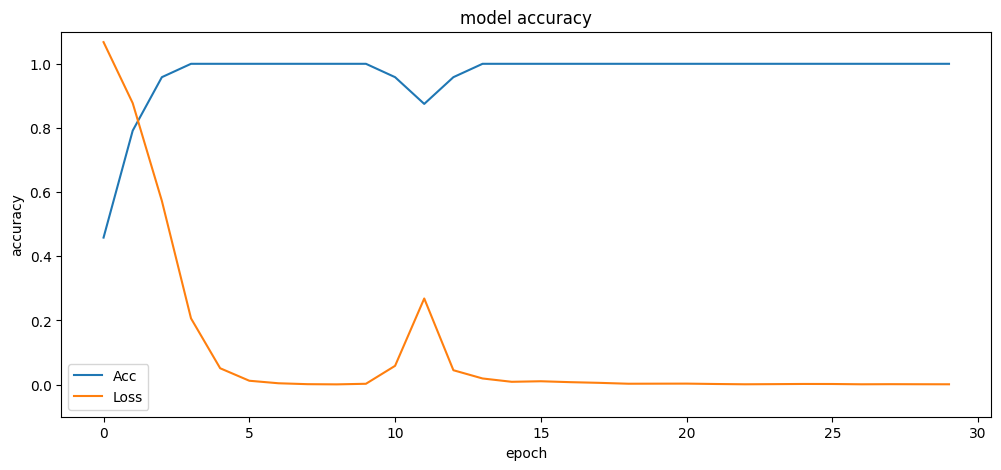

In [26]:
# Graficar el modelo NI
Grafica_Modelo(history_NI)

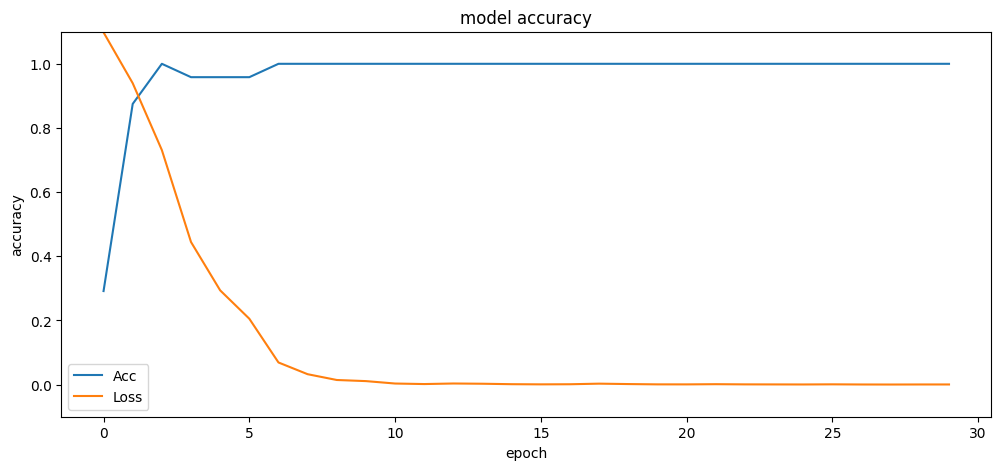

In [27]:
# Graficar el modelo NIIA
Grafica_Modelo(history_NIIA)

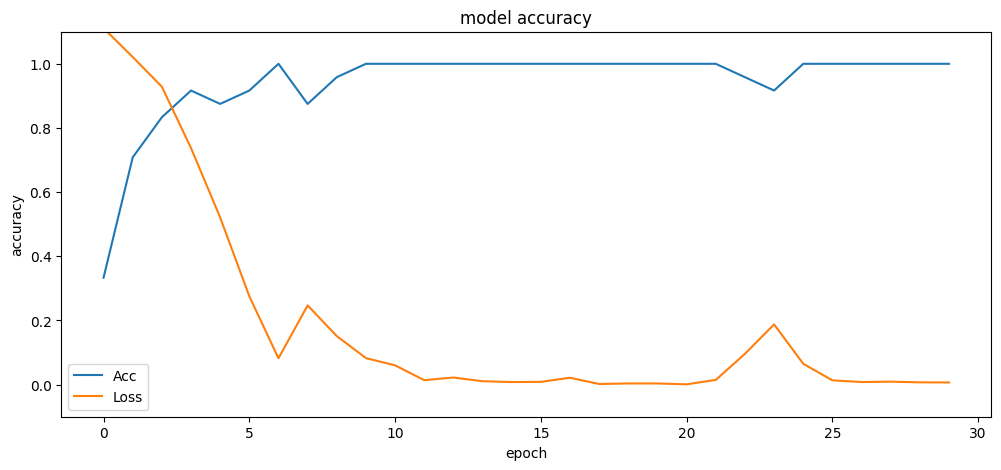

In [28]:
# Graficar el modelo NIIB
Grafica_Modelo(history_NIIB)

# Programación del Árbol conversacional

In [29]:
# El árbol conversacional debe de estar en un estado específico
# iniciar en el nivel contextual 1, e ir avanzando conforme a
# las decisiones que toma el usuario, como si fuera una máquina 
# de estados

def instancer(inp, model, tags):
    inp = inp.lower().replace("á", "a").replace("é", "e").replace("í", "i").replace("ó", "o")
    inp = inp.replace("ú", "u").replace("¿", "").replace("?", "")
    txt = [inp]
    seq = tokenizer_NI.texts_to_sequences(txt)
    padded = pad_sequences(seq, maxlen=maxlen)
    results = model.predict(padded)
    results_index = numpy.argmax(results)
    tag = list(tags.keys())[results_index]
    maxscore = numpy.max(results)
    return tag, maxscore

In [30]:
# Función del Nivel contextual 1:
def Activar_NI():
    # Pregunta inicial cuando se ingresa en el nivel contextual NI
    print("\nChatBot: ¿En qué puedo ayudarte?\n")    
    
    while True:
        inp = input("     Tú: ")
        tag, maxscore = instancer(inp, model_NI, NI)
        
        if maxscore > 0.8 or inp == 'salir':
            break
        else:
            print("\nChatBot: Lo siento, pero no entendí tu petición, ¿Podrías decirlo de otra forma?\n")
    
    if inp == 'salir':
        print("\nChatBot: Hasta luego, fue un gusto hablar contigo\n")
        return 'salir'
    
    if tag == 'Jugar_Juego':
        if inp.count('adivinanzas') > 0:
            return 'NIIA1'
        elif inp.count('20 preguntas') > 0:
            return 'NIIA2'
        elif inp.count('cierto o falso') > 0:
            return 'NIIA3'
        else:
            return 'NIIA'
    
    if tag == 'Reproducir_Musica':
        if inp.count('youtube') > 0:
            return 'NIIB1'
        elif inp.count('spotify') > 0:
            return 'NIIB2'
        elif inp.count('amazon') > 0:
            return 'NIIB3'
        else:
            return 'NIIB'
    
    if tag =='Mortal_Kombat':
        return 'NIIC'


In [31]:
# Función del Nivel contextual IIA:
def Activar_NIIA():
    # Pregunta inicial cuando se ingresa en el nivel contextual NIIA
    print("\nChatBot: Perfecto ¿Qué te gustaría jugar?\n")    
    
    while True:
        inp = input("     Tú: ")
        tag, maxscore = instancer(inp, model_NIIA, NIIA)
        
        if maxscore > 0.5 or inp == 'salir' or inp == 'volver':
            break
        else:
            print("\nChatBot: Lo siento, pero no entendí ¿Qué juego quieres jugar?\n")
    
    if inp == 'volver':
        return 'NI'
    
    if inp == 'salir':
        print("\nChatBot: Hasta luego, fue un gusto hablar contigo\n")
        return 'salir'
    
    if tag == 'Adivinanzas':
        return 'NIIA1'
    
    if tag == '20_preguntas':
        return 'NIIA2'
    
    if tag == 'Cierto_Falso':
        return 'NIIA3'

In [32]:
# Función del Nivel contextual IIB:
def Activar_NIIB():
    # Pregunta inicial cuando se ingresa en el nivel contextual NIIA
    print("\nChatBot: Perfecto ¿En qué plataforma te gustaría escuchar música?\n")    
    
    while True:
        inp = input("     Tú: ")
        tag, maxscore = instancer(inp, model_NIIB, NIIB)
        
        if maxscore > 0.5 or inp == 'salir' or inp == 'volver':
            break
        else:
            print("\nChatBot: Lo siento, pero no entendí ¿Qué plataforma quieres usar?\n")
    
    if inp == 'volver':
        return 'NI'
    
    if inp == 'salir':
        print("\nChatBot: Hasta luego, fue un gusto hablar contigo\n")
        return 'salir'
    
    if tag == 'Youtube':
        return 'NIIB1'
    
    if tag == 'Spotify':
        return 'NIIB2'
    
    if tag == 'Amazon':
        return 'NIIB3'

In [33]:
# Función del Nivel contextual IIB:
def Activar_NIIC():
    # Pregunta inicial cuando se ingresa en el nivel contextual NIIA
    print("\nChatBot: Perfecto ¿Qué quieres saber de Mortal Kombat?\n")    
    
    while True:
        inp = input("     Tú: ")
        tag, maxscore = instancer(inp, model_NIIB, NIIB)
        
        if maxscore > 0.5 or inp == 'salir' or inp == 'volver':
            break
        else:
            print("\nChatBot: Lo siento, pero no entendí ¿Qué plataforma quieres usar?\n")
    
    if inp == 'volver':
        return 'NI'
    
    if inp == 'salir':
        print("\nChatBot: Hasta luego, fue un gusto hablar contigo\n")
        return 'salir'

In [34]:
# Función del Nivel contextual IIA1:
def Activar_NIIA1():
    # Pregunta inicial cuando se ingresa en el nivel contextual NIIA1
    print("\nChatBot: Genial, adivinanzas, ¿Sobre qué tema quieres jugar?\n")    
    
    while True:
        inp = input("     Tú: ").lower()
        
        if inp == 'volver':
            return 'NI'
        elif inp == 'salir':
            print("\nChatBot: Hasta luego, fue un gusto hablar contigo\n")
            return 'salir'
        elif inp.count('animales') > 0:
            print("\nChatBot: Muy bien, serán adivinanzas de Animales entonces, vamos a empezar\n")
            return 'salir'
        elif inp.count('planetas') > 0:
            print("\nChatBot: Muy bien, serán adivinanzas de Planetas entonces, vamos a empezar\n")
            return 'salir'
        elif inp.count('paises') > 0:
            print("\nChatBot: Muy bien, serán adivinanzas de Países entonces, vamos a empezar\n")
            return 'salir'
        else:
            print("\nChatBot: ¿Podrías repetirme qué tipo de adivinanzas quieres jugar?\n")

In [35]:
# Función del Nivel contextual IIA2:
def Activar_NIIA2():
    # Pregunta inicial cuando se ingresa en el nivel contextual NIIA2
    print("\nChatBot: Genial, 20 preguntas, ¿En qué dificultad quieres jugar?\n")    
    
    while True:
        inp = input("     Tú: ").lower()
        
        if inp == 'volver':
            return 'NI'
        elif inp == 'salir':
            print("\nChatBot: Hasta luego, fue un gusto hablar contigo\n")
            return 'salir'
        elif inp.count('facil') > 0:
            print("\nChatBot: Muy bien, será un juego tranquilo y fáci entonces\n")
            return 'salir'
        elif inp.count('media') > 0:
            print("\nChatBot: Muy bien, será la dificultad estándar entonces\n")
            return 'salir'
        elif inp.count('dificil') > 0:
            print("\nChatBot: Muy bien, parece que te gustan los retos, será la dificultad difícil\n")
            return 'salir'
        else:
            print("\nChatBot: ¿Podrías repetirme qué tipo de adivinanzas quieres jugar?\n")

In [36]:
# Función del Nivel contextual IIB1:
def Activar_NIIB1():
    # Pregunta inicial cuando se ingresa en el nivel contextual NIIA1
    print("\nChatBot: ¿Tienes contratado Youtube Premium?\n")    
    
    while True:
        inp = input("     Tú: ").lower()
        
        if inp == 'volver':
            return 'NI'
        elif inp == 'salir':
            print("\nChatBot: Hasta luego, fue un gusto hablar contigo\n")
            return 'salir'
        elif inp == 'si':
            print("\nChatBot: Muy bien, comenzaré con la reproducción\n")
            return 'salir'
        elif inp == 'no':
            print("\nChatBot: Lo siento, pero no puedo hacer eso si no cuentas con el servicio\n")
            return 'salir'
        else:
            print("\nChatBot: Esperaba una respuesta tal como Sí o No\n")

In [37]:
# Función del Nivel contextual IIB2:
def Activar_NIIB2():
    # Pregunta inicial cuando se ingresa en el nivel contextual NIIA1
    print("\nChatBot: ¿Tienes contratado Spotify?\n")    
    
    while True:
        inp = input("     Tú: ").lower()
        
        if inp == 'volver':
            return 'NI'
        elif inp == 'salir':
            print("\nChatBot: Hasta luego, fue un gusto hablar contigo\n")
            return 'salir'
        elif inp == 'si':
            print("\nChatBot: Muy bien, comenzaré con la reproducción\n")
            return 'salir'
        elif inp == 'no':
            print("\nChatBot: Lo siento, pero no puedo hacer eso si no cuentas con el servicio\n")
            return 'salir'
        else:
            print("\nChatBot: Esperaba una respuesta tal como Sí o No\n")

In [38]:
# Función del Nivel contextual IIB3:
def Activar_NIIB3():
    # Pregunta inicial cuando se ingresa en el nivel contextual NIIA1
    print("\nChatBot: ¿Tienes contratado Amazon Music?\n")    
    
    while True:
        inp = input("     Tú: ").lower()
        
        if inp == 'volver':
            return 'NI'
        elif inp == 'salir':
            print("\nChatBot: Hasta luego, fue un gusto hablar contigo\n")
            return 'salir'
        elif inp == 'si':
            print("\nChatBot: Muy bien, comenzaré con la reproducción\n")
            return 'salir'
        elif inp == 'no':
            print("\nChatBot: ¿Te gustaría contratarlo ahora?\n")
            return 'salir'
        else:
            print("\nChatBot: Esperaba una respuesta tal como Sí o No\n")

In [39]:
# Implementación de casos correspondientes para cada nivel del ChatBot
# Nivel contextual inicial por defecto, el primero

maquina_estados = {'NI': Activar_NI,
                   'NIIA': Activar_NIIA,
                   'NIIA1': Activar_NIIA1,
                   'NIIA2': Activar_NIIA2,
                   'NIIB': Activar_NIIB,
                   'NIIB1': Activar_NIIB1,
                   'NIIB2': Activar_NIIB2,
                   'NIIB3': Activar_NIIB3,
                   'NIIC': Activar_NIIC}

def chat1():  
    Nivel = 'NI'
    #Pregunta inicial, solo cuando se inicia el ChatBot
    print("\nChatBot: Hola, soy el ChatBot, comienza a Hablar conmigo")
    
    while True:        
        Nivel = maquina_estados[Nivel]()
        print(Nivel)
        if Nivel == 'salir':
            break

In [43]:
# Activar el ChatBot
chat1()


ChatBot: Hola, soy el ChatBot, comienza a Hablar conmigo

ChatBot: ¿En qué puedo ayudarte?

1/1 [==============================] - 0s 25ms/step

ChatBot: Lo siento, pero no entendí tu petición, ¿Podrías decirlo de otra forma?

1/1 [==============================] - 0s 22ms/step
NIIC

ChatBot: Perfecto ¿Qué quieres saber de Mortal Kombat?

1/1 [==============================] - 0s 21ms/step

ChatBot: Lo siento, pero no entendí ¿Qué plataforma quieres usar?

1/1 [==============================] - 0s 25ms/step

ChatBot: Lo siento, pero no entendí ¿Qué plataforma quieres usar?

1/1 [==============================] - 0s 21ms/step

ChatBot: Lo siento, pero no entendí ¿Qué plataforma quieres usar?

